In [1]:
from sklearn.utils import shuffle
from keras.datasets import mnist
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.layers import Input, Dense, LeakyReLU,ZeroPadding2D, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization, MaxPooling2D, Reshape, UpSampling2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import models
from collections import Counter
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.models import load_model, Model, Sequential
import numpy as np
from PIL import Image
from tqdm import tqdm
import random
import scikitplot as skplt
from sklearn.metrics import classification_report

Using TensorFlow backend.


### Data

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images / 127.5 - 1.
test_images = test_images / 127.5 - 1.

train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

# train_labels = to_categorical(train_labels) 
test_labsl_nocat = test_labels
test_labels = to_categorical(test_labels)


x, y = shuffle(train_images, train_labels, random_state=15)
x_train = x[0:100]
y_train = y[0:100].reshape(-1, 1)
y_train = to_categorical(y_train) 

### Classifier 

In [48]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64,(3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

In [49]:
n = Dense(128, activation='relu')(model.layers[-1].output)
v1 = Dropout(0.4)(n)
validity = Dense(1, activation='sigmoid')(v1)

q_net = Dense(256, activation='relu')(model.layers[-1].output)
dp = Dropout(0.5)(q_net)
label = Dense(10, activation='softmax')(dp)

In [50]:
optimizer = Adam(0.00005, 0.5)

validity_model = Model(model.input, validity)
validity_model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['binary_accuracy'])

classifier_model = Model(model.input, label)
classifier_model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['categorical_accuracy'])

### Training

In [39]:
batch_size = 32
epoch = 10000

In [40]:
generator = [load_model("models/gans/dcgan/generator.hdf5"), load_model("models/wgan/generator.hdf5") , load_model("models/dcgan2/generator.hdf5")]

In [61]:
datagen = ImageDataGenerator(
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.08, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [42]:
fake = np.zeros((batch_size, 1))
valid = np.ones((batch_size, 1))

In [43]:
### train validity
best_acc = 0

In [74]:
for e in range(2):
    for x in range(20):
#         validity_model.trainable = True
        
#         ### train validity
#         noise = np.random.normal(0, 1, (batch_size, 100))
#         fakes_imgs = generator[random.randint(0,2)].predict(noise)

#         idx = np.random.randint(0, train_images.shape[0], batch_size)
#         real_imgs = train_images[idx]

#         validity_inputs = np.concatenate((fakes_imgs, real_imgs))
#         validity_labels = np.concatenate((fake, valid))
#         x_validity, y_validity = shuffle(validity_inputs, validity_labels)

#         validity_loss = validity_model.train_on_batch(x_validity, y_validity)
        
#         validity_model.trainable = False
        
        ### train classifier
        
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        x_train_class = x_train[idx]
        y_train_class = y_train[idx]
#         x_train_class = next(datagen.flow(x_train_class, batch_size=32, shuffle=False))
        
        classifier_model.train_on_batch(x_train_class, y_train_class)
    
    test_loss, test_acc = classifier_model.evaluate(test_images, test_labels)
    print("Epoch : ", e, " Accuracy : ", test_acc)
    if test_acc > best_acc:
        classifier_model.save("models/custom/classifier2.h5")
        best_acc = test_acc

10000/10000 [==============================] - 1s 78us/step
('Epoch : ', 0, ' Accuracy : ', 0.9525)
10000/10000 [==============================] - 1s 77us/step
('Epoch : ', 1, ' Accuracy : ', 0.9521)


In [75]:
test_model = load_model("models/custom/classifier2.h5")
test_loss, test_acc = test_model.evaluate(test_images, test_labels)
test_acc

10000/10000 [==============================] - 2s 156us/step


0.9529

In [76]:
# test_model.save("models/custom/best_classifier.h5")

In [22]:
pred = np.argmax(classifier_model.predict(test_images), axis=1)

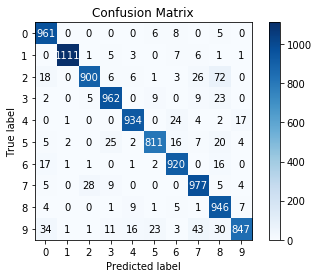

In [23]:
skplt.metrics.plot_confusion_matrix(np.argmax(test_labels, axis=1), pred)

In [24]:
print(classification_report(np.argmax(test_labels, axis=1), pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       980
           1       1.00      0.98      0.99      1135
           2       0.96      0.87      0.91      1032
           3       0.94      0.95      0.95      1010
           4       0.96      0.95      0.96       982
           5       0.95      0.91      0.93       892
           6       0.93      0.96      0.95       958
           7       0.91      0.95      0.93      1028
           8       0.84      0.97      0.90       974
           9       0.96      0.84      0.90      1009

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

